Starting training with stability improvements...
Iter 001 │ Policy Loss: 0.0078 │ Push MSE: 1.5006 │ Δ=1.4214 │ L2=1.2308
Iter 010 │ Policy Loss: 0.0074 │ Push MSE: 1.2116 │ Δ=0.4604 │ L2=1.3736
Iter 020 │ Policy Loss: 0.0087 │ Push MSE: 0.9159 │ Δ=0.2386 │ L2=0.7001
Iter 030 │ Policy Loss: 0.0052 │ Push MSE: 0.6042 │ Δ=0.6875 │ L2=1.1479
Iter 040 │ Policy Loss: 0.0067 │ Push MSE: 0.2821 │ Δ=1.5765 │ L2=0.9363
Iter 050 │ Policy Loss: 0.0081 │ Push MSE: 0.0781 │ Δ=1.4754 │ L2=0.6761
Iter 060 │ Policy Loss: 0.0085 │ Push MSE: 0.0378 │ Δ=1.2619 │ L2=0.3968
Iter 070 │ Policy Loss: 0.0103 │ Push MSE: 0.0336 │ Δ=1.3421 │ L2=0.2049
Iter 080 │ Policy Loss: 0.0084 │ Push MSE: 0.0237 │ Δ=1.0475 │ L2=0.1557
Iter 090 │ Policy Loss: 0.0095 │ Push MSE: 0.0203 │ Δ=1.2153 │ L2=0.1416
Iter 100 │ Policy Loss: 0.0086 │ Push MSE: 0.0105 │ Δ=0.6238 │ L2=0.1033
Iter 110 │ Policy Loss: 0.0064 │ Push MSE: 0.0106 │ Δ=0.8012 │ L2=0.1079
Iter 120 │ Policy Loss: 0.0077 │ Push MSE: 0.0085 │ Δ=0.6605 │ L2=0.0946
It

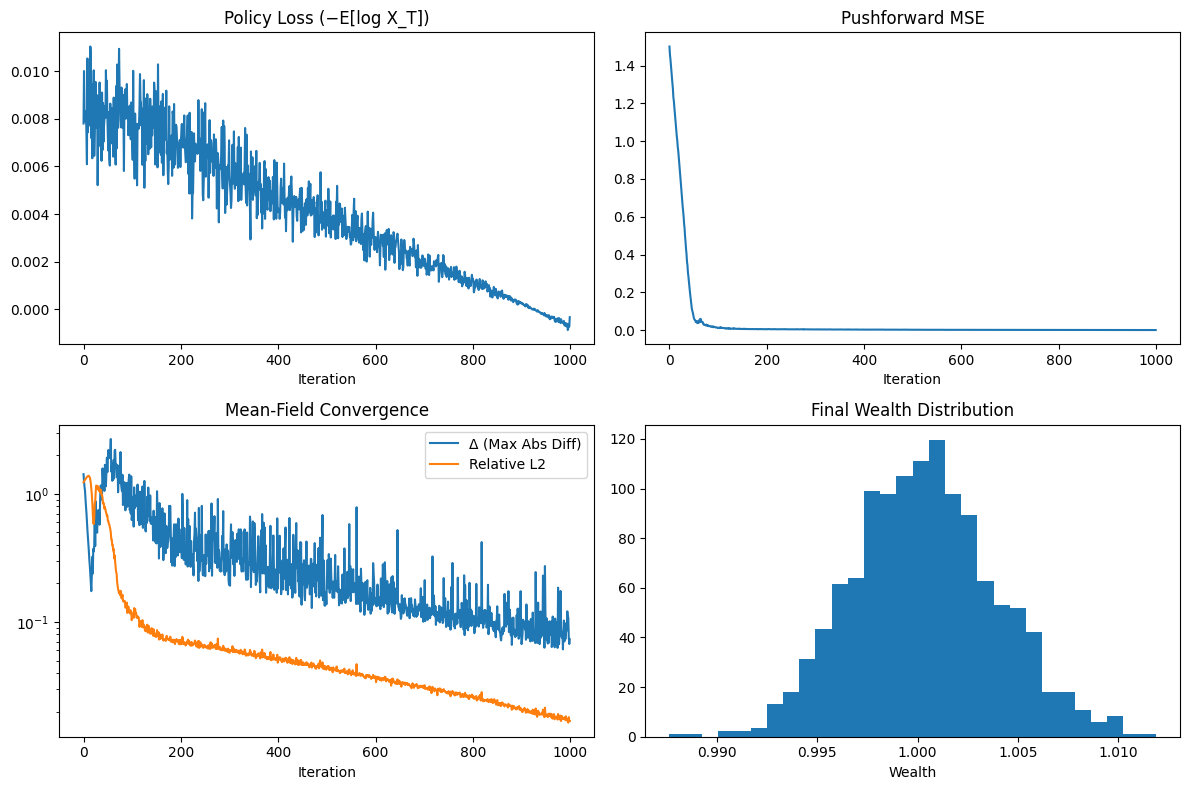

: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import signatory
import matplotlib.pyplot as plt


# === Hyper-parameters ===
T, K = 1.0, 100
dt      = T/K
N       = 1024  # <<< CHANGE: Increased batch size for stability
M       = 2
mu, nu, sigma = 0.05, 0.2, 0.15
X0      = 1.0
ROUNDS  = 1000

MF_ALPHA = 0.1 # <<< CHANGE: Added a fixed smoothing factor for the mean-field update

# Pushforward GAN settings
z_dim = 4
M_z   = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# (Keep the utility, rel_L2, make_policy, PushReg, and simulate functions as they were)
def utility(x): return torch.log(x + 1e-8)
def rel_L2(curr, prev, dt):
    num = np.mean(np.sum((curr - prev)**2, axis=1) * dt)
    den = np.mean(np.sum(prev**2, axis=1) * dt)
    return np.sqrt(num / (den + 1e-9))
def make_policy():
    return nn.Sequential(nn.Linear(3, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1)).to(device)
class PushReg(nn.Module):
    def __init__(self, sig_dim, z_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(sig_dim + z_dim, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
    def forward(self, sigs, zs):
        N, Mz, _ = zs.shape
        e = sigs.unsqueeze(1).expand(-1, Mz, -1)
        inp = torch.cat([e, zs], 2).reshape(N * Mz, -1)
        return self.net(inp).view(N, Mz)
def simulate(policy, mean_field, dW, dB):
    time_grid = torch.linspace(0, T, K+1).unsqueeze(0).unsqueeze(2).repeat(N,1,1).to(device)
    B = torch.cumsum(dB, dim=1)
    path = torch.cat([time_grid[:, :-1], B], dim=2)
    sig = signatory.signature(path, depth=M)
    X = torch.zeros(N, K+1, 1, device=device)
    X[:, 0, 0] = X0
    for k in range(K):
        t = time_grid[:, k]; x = X[:, k]; m = mean_field[:, k]
        pi = policy(torch.cat([t, x, m], 1))
        dX = pi * (mu * dt + nu * dW[:, k] + sigma * dB[:, k])
        X[:, k+1] = x + dX
    return X, sig

# ── Build models & optimizers ─────────────────────
policy = make_policy()
# <<< CHANGE: Significantly reduced policy learning rate
optP   = torch.optim.Adam(policy.parameters(), lr=1e-5) 

sig_dim = signatory.signature_channels(2, M)
push    = PushReg(sig_dim, z_dim).to(device)
optG    = torch.optim.Adam(push.parameters(), lr=1e-3)

# ── Initialize mean field, histories ─────────────
mf = torch.full((N, K+1, 1), X0, device=device)
histP, histG, histD, histL2 = [], [], [], []

print("Starting training with stability improvements...")
for it in range(1, ROUNDS+1):
    dW = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    dB = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    old_mean = mf.detach().cpu().squeeze(-1).numpy()

    # ── GAN (pushforward) training ─────────────────
    with torch.no_grad():
        X1, sig1 = simulate(policy, mf, dW, dB)
        X1_T = X1[:, -1, 0]
    
    zs = torch.randn(N, M_z, z_dim, device=device)
    preds = push(sig1, zs).mean(1)
    lossG = nn.MSELoss()(preds, X1_T)
    optG.zero_grad(); lossG.backward(); optG.step()

    # ── Update mean field ───────────────────────────
    new_mean_detached = preds.view(N, 1, 1).expand(-1, K + 1, -1).detach()
    Δ = (mf - new_mean_detached).abs().max().item()
    cur = new_mean_detached.cpu().squeeze(-1).numpy()
    L2 = rel_L2(cur, old_mean, dt)

    # <<< CHANGE: Replaced fictitious play with exponential moving average for stability
    mf = (1 - MF_ALPHA) * mf + MF_ALPHA * new_mean_detached

    # ── Policy training ─────────────────────────────
    X2, _ = simulate(policy, mf, dW, dB)
    X2_T = X2[:, -1, 0]
    lossP = -utility(X2_T).mean()
    optP.zero_grad(); lossP.backward(); optP.step()

    # ── Logging ─────────────────────────────────────
    histP.append(lossP.item())
    histG.append(lossG.item())
    histD.append(Δ)
    histL2.append(L2)
    if it % 10 == 0 or it == 1:
      print(f"Iter {it:03d} │ Policy Loss: {lossP:.4f} │ Push MSE: {lossG:.4f} │ Δ={Δ:.4f} │ L2={L2:.4f}")

print("Training finished.")
# (Visualization code remains the same)
plt.figure(figsize=(12, 8))
plt.subplot(221); plt.plot(histP); plt.title("Policy Loss (−E[log X_T])"); plt.xlabel("Iteration")
plt.subplot(222); plt.plot(histG); plt.title("Pushforward MSE"); plt.xlabel("Iteration")
plt.subplot(223)
plt.plot(histD, label='Δ (Max Abs Diff)')
plt.plot(histL2, label='Relative L2')
plt.legend(); plt.title("Mean-Field Convergence"); plt.xlabel("Iteration"); plt.yscale("log")
plt.subplot(224)
plt.hist(X2[:, -1, 0].detach().cpu().numpy(), bins=30, density=True)
plt.title("Final Wealth Distribution"); plt.xlabel("Wealth")
plt.tight_layout()
plt.savefig("output_base.png", dpi=150)   # this writes real PNG data!
plt.show()